In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import matplotlib.dates as mdates
from netCDF4 import default_fillvals

In [2]:
direc = '/Users/diana/Dropbox/UW/Research/rasm/25_km'
params_filename = 'vic_params_wr50a_vic5.0.dev_20160328.nc'
domain_filename = 'domain.lnd.wr50a_ar9v4.100920.nc'
domain = xr.open_dataset(os.path.join(direc, domain_filename))
params = xr.open_dataset(os.path.join(direc, params_filename))

look at initial soil moisture to make sure it has actual values. 

Just verified in the VIC source code that it's actually used for a cold start in the same way that I expected based on the old VIC documentation. 

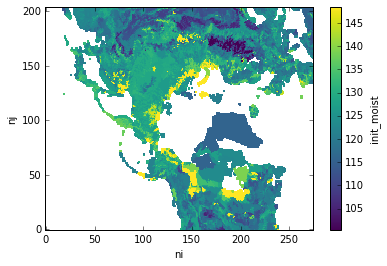

In [3]:
params.init_moist.isel(nlayer=0).plot()

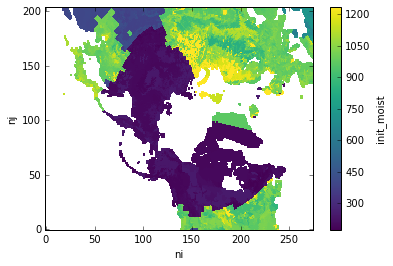

In [4]:
params.init_moist.isel(nlayer=1).plot()

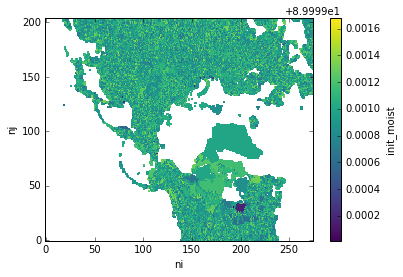

In [5]:
params.init_moist.isel(nlayer=2).plot()

To make layers saturated: multiply `(bulk density / soil density) * layer depth` for each layer and replace `init_moist` for each layer with those values

Units: 

thickness of each layer in m. 

init_moist in mm. 

so answer below needs to be multiplied by 1000. 

In [6]:
porosity_layer1 = (params.bulk_density.isel(nlayer=0).where(domain.mask == 1).values / 
                   params.soil_density.isel(nlayer=0).where(domain.mask == 1).values)
porosity_layer2 = (params.bulk_density.isel(nlayer=1).where(domain.mask == 1).values / 
                   params.soil_density.isel(nlayer=1).where(domain.mask == 1).values)
porosity_layer3 = (params.bulk_density.isel(nlayer=2).where(domain.mask == 1).values / 
                   params.soil_density.isel(nlayer=2).where(domain.mask == 1).values)
thickness_layer1 = params.depth.isel(nlayer=0).where(domain.mask == 1).values
thickness_layer2 = params.depth.isel(nlayer=1).where(domain.mask == 1).values
thickness_layer3 = params.depth.isel(nlayer=2).where(domain.mask == 1).values

In [7]:
max_moist_layer1 = porosity_layer1 * thickness_layer1
max_moist_layer2 = porosity_layer2 * thickness_layer2
max_moist_layer3 = porosity_layer3 * thickness_layer3

In [10]:
np.nanmax(max_moist_layer3)*1000

166.666875

In [11]:
np.nanmax(params.init_moist.isel(nlayer=2).where(domain.mask == 1).values)

90.000683617904954

In [12]:
params.init_moist

<xarray.DataArray 'init_moist' (nlayer: 3, nj: 205, ni: 275)>
[169125 values with dtype=float64]
Coordinates:
    yc       (nj, ni) float64 16.53 16.78 17.02 17.27 17.51 17.76 18.0 18.25 ...
    xc       (nj, ni) float64 -170.8 -170.6 -170.4 -170.3 -170.1 -169.9 ...
Dimensions without coordinates: nlayer, nj, ni
Attributes:
    units:        mm
    description:  Initial layer moisture content
    long_name:    init_moist

In [13]:
'''params['init_moist'].isel(nlayer=0).where(domain.mask == 1).values = max_moist_layer1
params['init_moist'].isel(nlayer=1).where(domain.mask == 1).values = max_moist_layer2'''
params['init_moist'].values[0, :, :] = max_moist_layer1 * 1000
params['init_moist'].values[1, :, :] = max_moist_layer2 * 1000
params['init_moist'].values[2, :, :] = max_moist_layer3 * 1000

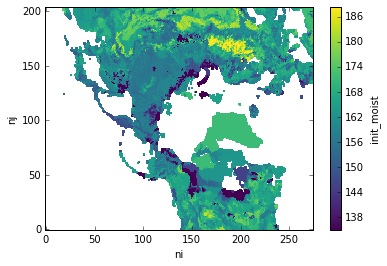

In [14]:
params.init_moist.isel(nlayer=0).plot()

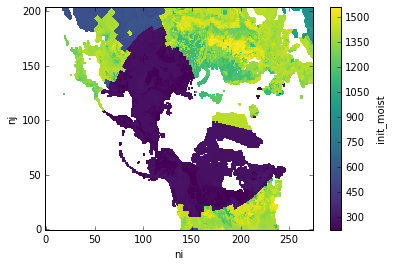

In [15]:
params.init_moist.isel(nlayer=1).plot()

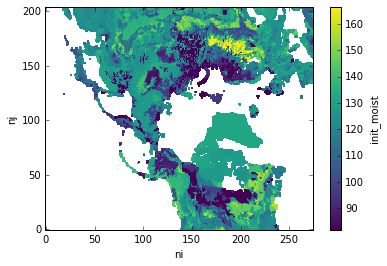

In [16]:
params.init_moist.isel(nlayer=2).plot()

the encoding we need to do properly so that VIC doesn't complain with the correct integer fillvalues 

In [17]:
fillval_i = default_fillvals['i4']
encoding_params = {'run_cell': {'dtype': 'int32', "_FillValue": fillval_i}, 
                   'gridcell': {'dtype': 'int32', "_FillValue": fillval_i}, 
                   'fs_active': {'dtype': 'int32', "_FillValue": fillval_i}, 
                   'Nveg': {'dtype': 'int32', "_FillValue": fillval_i},
                   'overstory': {'dtype': 'int32', "_FillValue": fillval_i}}

save updated parameters file 

In [18]:
direc_point_runs = '/Users/diana/Dropbox/UW/Research/rasm/agu_2017'
new_params_file = os.path.join(direc_point_runs, 'params.wr50a.saturated_soilmoist_layers_20171101.nc')

params.to_netcdf(new_params_file, format='NETCDF4_CLASSIC', encoding=encoding_params)